In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
m_sqrt_error = mean_squared_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm_notebook

from itertools import product
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('UnemploymentRateJan1986-Dec2018.csv')
data.head()
# Check and describe the format of date

,Months,Unemployment_Rates
0,Jan-86,8.53
1,Feb-86,8.92
2,Mar-86,8.48
3,Apr-86,8.06
4,May-86,7.71


In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates,'%b-%y')
data = pd.read_csv('UnemploymentRateJan1986-Dec2018.csv', parse_dates = ['Months'], index_col='Months', date_parser=dateparse)
ts = data['Unemployment_Rates']

In [4]:
data.describe()
# 没啥帮助

,Unemployment_Rates
count,396.000000
mean,6.726212
std,1.811832
min,3.930000
25%,5.410000
50%,6.210000
75%,7.947500
max,11.990000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1986-01-01 to 2018-12-01
Data columns (total 1 columns):
Unemployment_Rates    396 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


In [6]:
data.isnull().count()

Unemployment_Rates    396
dtype: int64

# EDA

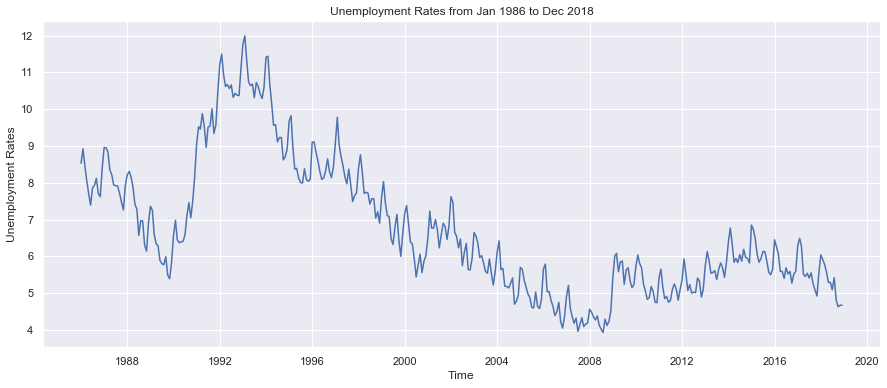

In [7]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

plt.figure()
plt.plot(ts)
plt.title('Unemployment Rates from Jan 1986 to Dec 2018')
plt.xlabel('Time')
plt.ylabel('Unemployment Rates')
plt.show()

In [8]:
# pattern observatrion
# with trend，first increased then declined
# may have seasonality but not sure
# has some noises

In [9]:
# Train-Test Split

test_size = 12
train_size = len(data) - test_size

train = data[:train_size]
test = data[-test_size:]

<Figure size 1080x432 with 0 Axes>

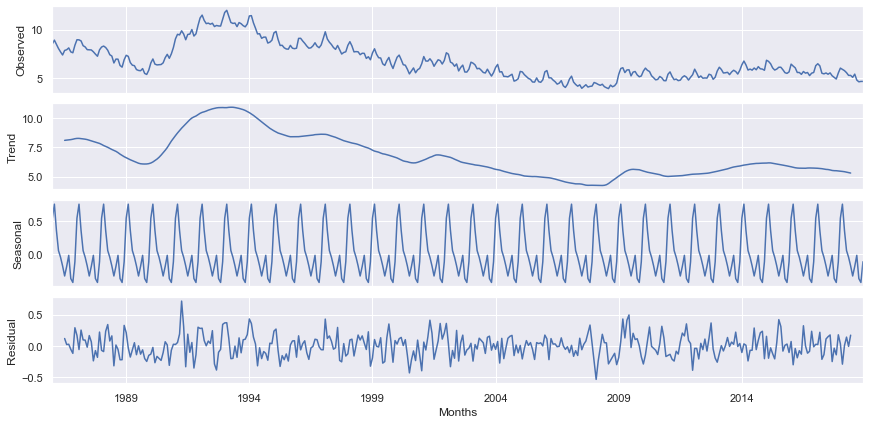

In [10]:
decomposition = seasonal_decompose(ts, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

## Decomposition - detailed version

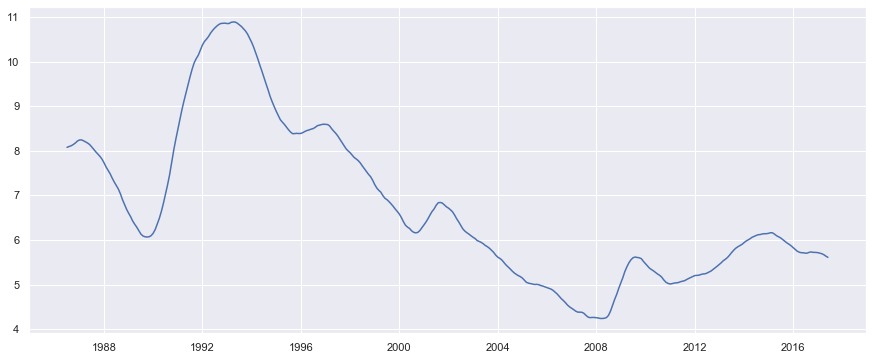

In [11]:
# step1: Initial trend estimate
# MA-12

plt.figure()
initial_trend = train.rolling(2, center = True).mean().rolling(12, center = True).mean().shift(-1)
plt.plot(initial_trend)

In [12]:
# additive or multiplicative? 

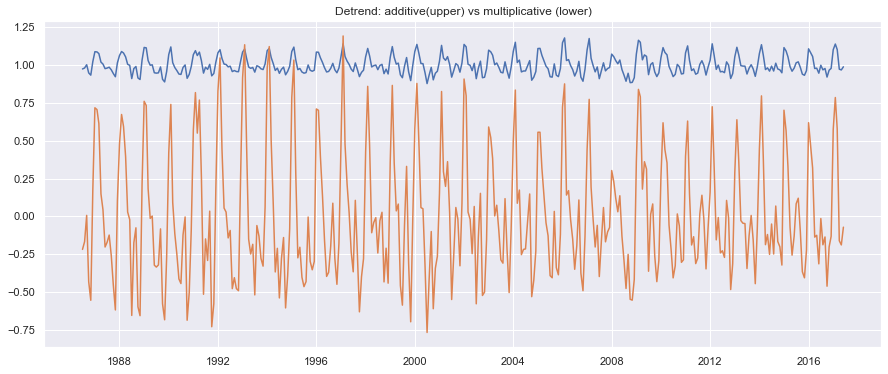

In [13]:
# step2: de-trend

detrend_mult = train/initial_trend
plt.figure()
plt.plot(detrend_mult)
plt.title('Detrend: multiplicative')

detrend_add = train-initial_trend
plt.figure
plt.plot(detrend_add)
plt.title('Detrend: additive(upper) vs multiplicative (lower)')

fig.set_size_inches(12, 6);

Both plots above seems reasonable in this case.The additive one has better outcome.

In [14]:
# step3: seasonal indices

detrend_add.head(10)

,Unemployment_Rates
Months,
1986-01-01,NaN
1986-02-01,NaN
1986-03-01,NaN
1986-04-01,NaN
1986-05-01,NaN
1986-06-01,NaN
1986-07-01,-0.217917
1986-08-01,-0.167083
1986-09-01,0.006667


In [15]:
detrend_add = np.nan_to_num(detrend_add)
print(len(detrend_add))
detrend_add[:10]

384


array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.21791667],
       [-0.16708333],
       [ 0.00666667],
       [-0.43041667]])

In [16]:
detrend_add.shape

(384, 1)

In [17]:
monthly_si = np.reshape(detrend_add,(32,12))
monthly_avg = np.mean(monthly_si, axis=0) * 32/31
pd.DataFrame(monthly_avg)

,0
0,0.547056
1,0.772581
2,0.359960
3,0.048629
4,-0.048737
5,-0.187083
6,-0.340591
7,-0.194315
8,-0.011626
9,-0.374261


In [18]:
# Normalisation? Not obvious results

In [19]:
# tile

tiled_avg = np.tile(monthly_avg,32)
tiled_avg = np.reshape(tiled_avg,(12*32, 1))
pd.DataFrame(tiled_avg)

,0
0,0.547056
1,0.772581
2,0.359960
3,0.048629
4,-0.048737
5,-0.187083
6,-0.340591
7,-0.194315
8,-0.011626
9,-0.374261


Text(0.5, 1.0, 'Seasonal patterns')

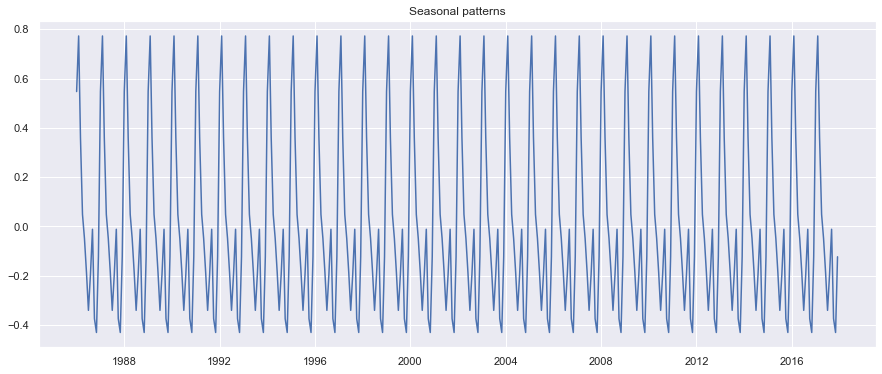

In [20]:
plt.figure()
plt.plot(data.index[:-12], tiled_avg)
plt.title('Seasonal patterns')

Text(0.5, 1.0, 'Seasonally adjusted data')

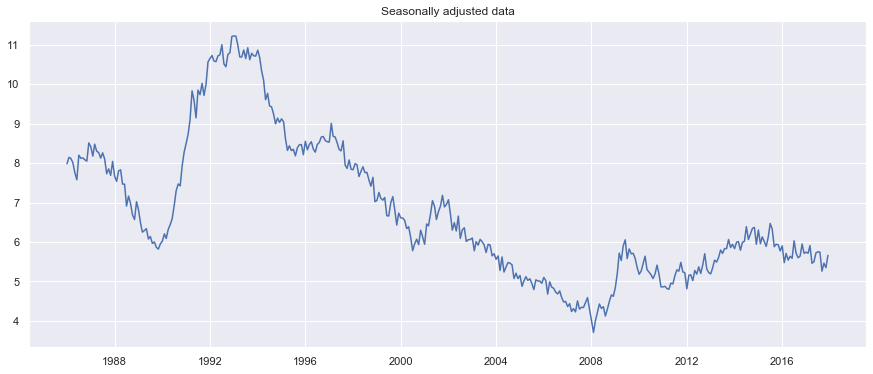

In [21]:
# step4: De-seasonal

seasonally_adjusted = train - tiled_avg
plt.figure()
plt.plot(seasonally_adjusted)
plt.title('Seasonally adjusted data')

In [22]:
# step5: obtain trend component using MA-2. This reason is that we don't want to lose more data

trend = seasonally_adjusted.rolling(2, center = True).mean().rolling(2, center = True).mean().shift(-1)
trend.shape

(384, 1)

In [23]:
trend

,Unemployment_Rates
Months,
1986-01-01,NaN
1986-02-01,8.099456
1986-03-01,8.099718
1986-04-01,7.975380
1986-05-01,7.776482
1986-06-01,7.778374
1986-07-01,8.025645
1986-08-01,8.145212
1986-09-01,8.117957


In [24]:
trend_modified = trend.iloc[1:-1]

In [25]:
trend_modified

,Unemployment_Rates
Months,
1986-02-01,8.099456
1986-03-01,8.099718
1986-04-01,7.975380
1986-05-01,7.776482
1986-06-01,7.778374
1986-07-01,8.025645
1986-08-01,8.145212
1986-09-01,8.117957
1986-10-01,8.087631


Text(0.5, 1.0, 'Trend')

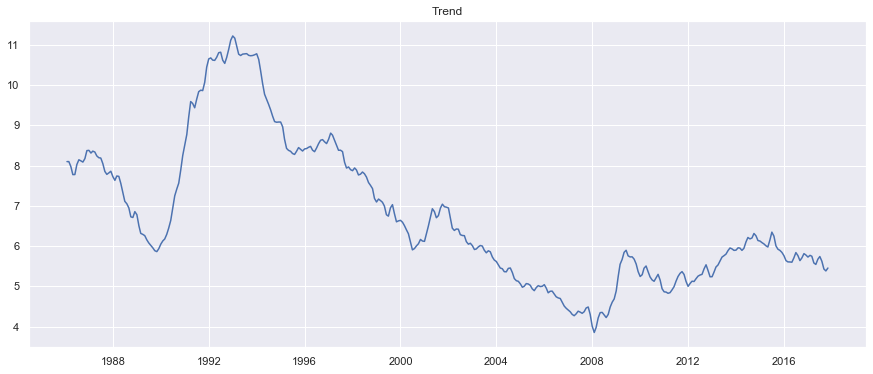

In [26]:
plt.figure()
plt.plot(trend_modified)
plt.title('Trend')

## Forecast

In [27]:
decomp_list = trend_modified['Unemployment_Rates'].to_list()
for i in range (13):
    decomp_list.append(np.mean(decomp_list[-2:]))

In [28]:
len(decomp_list)

395

In [29]:
forecast_trend = decomp_list[-12:]
forecast_trend

[5.439080141129034,
 5.430088625672045,
 5.43458438340054,
 5.432336504536293,
 5.433460443968416,
 5.4328984742523545,
 5.433179459110385,
 5.433038966681369,
 5.433109212895877,
 5.433074089788623,
 5.4330916513422505,
 5.433082870565437]

In [30]:
forecast_seasonal = tiled_avg[:12]
forecast_seasonal

array([[ 0.54705645],
       [ 0.77258065],
       [ 0.35995968],
       [ 0.04862903],
       [-0.04873656],
       [-0.18708333],
       [-0.3405914 ],
       [-0.19431452],
       [-0.01162634],
       [-0.37426075],
       [-0.43037634],
       [-0.12323925]])

In [31]:
forecast_decomposition = (forecast_trend + forecast_seasonal.T).T
forecast_decomposition

array([[5.98613659],
       [6.20266927],
       [5.79454406],
       [5.48096554],
       [5.38472388],
       [5.24581514],
       [5.09258806],
       [5.23872445],
       [5.42148287],
       [5.05881334],
       [5.00271531],
       [5.30984362]])

Text(0, 0.5, 'Unemplotment Rates')

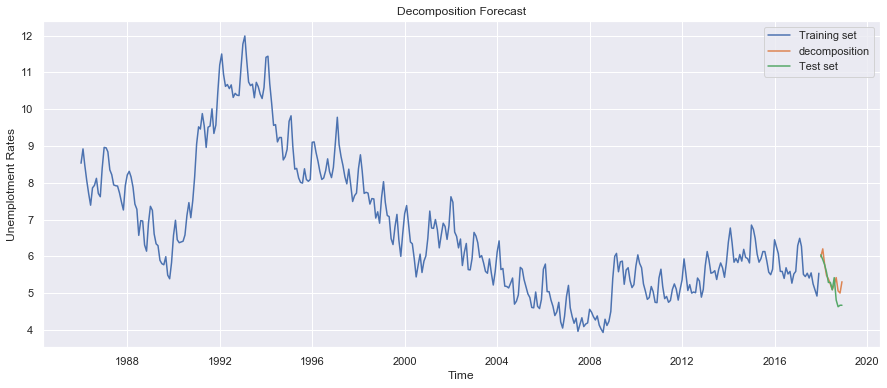

In [32]:
plt.figure()
plt.plot(train,label = 'Training set')
plt.plot(test.index, pd.DataFrame(forecast_decomposition),label = 'decomposition')
plt.plot(test,label = 'Test set')
plt.legend()
plt.title('Decomposition Forecast')
plt.xlabel('Time')
plt.ylabel('Unemplotment Rates')

Decomposition looks good

In [33]:
# MSE for decomposition
from sklearn.metrics import mean_squared_error

decomp_pred = forecast_decomposition
decomp_true = test
mean_squared_error(decomp_true, decomp_pred)

0.10153159899306426